In [1]:
import copy


class CliffWalkingEnv:
    """ 悬崖漫步环境"""
    def __init__(self, ncol=12, nrow=4):
        self.ncol = ncol  # 定义网格世界的列
        self.nrow = nrow  # 定义网格世界的行
        # 转移矩阵P[state][action] = [(p, next_state, reward, done)]包含下一个状态和奖励
        self.P = self.createP()

    def createP(self):
        # 初始化
        P = [[[] for j in range(4)] for i in range(self.nrow * self.ncol)]
        # 4种动作, change[0]:上,change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        for i in range(self.nrow):
            for j in range(self.ncol):
                for a in range(4):
                    # 位置在悬崖或者目标状态,因为无法继续交互,任何动作奖励都为0
                    if i == self.nrow - 1 and j > 0:
                        P[i * self.ncol + j][a] = [(1, i * self.ncol + j, 0,True)]
                        continue
                    # 其他位置
                    next_x = min(self.ncol - 1, max(0, j + change[a][0]))
                    next_y = min(self.nrow - 1, max(0, i + change[a][1]))
                    next_state = next_y * self.ncol + next_x
                    reward = -1
                    done = False
                    # 下一个位置在悬崖或者终点
                    if next_y == self.nrow - 1 and next_x > 0:
                        done = True
                        if next_x != self.ncol - 1:  # 下一个位置在悬崖
                            reward = -100
                    P[i * self.ncol + j][a] = [(1, next_state, reward, done)]
        return P

In [2]:
nrow=4
ncol=4
P = [[[] for j in range(4)] for i in range(nrow * ncol)]
P

[[[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []],
 [[], [], [], []]]

In [3]:
class PolicyIteration:
    """ 策略迭代算法 """
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.pi = [[0.25, 0.25, 0.25, 0.25]
                   for i in range(self.env.ncol * self.env.nrow)]  # 初始化为均匀随机策略
        self.theta = theta  # 策略评估收敛阈值
        self.gamma = gamma  # 折扣因子、
        #print(self.pi,self.v,self.theta,self.gamma)
        #print('self.env',self.env.P)

    def policy_evaluation(self):  # 策略评估
        cnt = 1  # 计数器
        while 1:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
                for a in range(4):
                    qsa = 0
                    for res in self.env.P[s][a]:
                        #print('self.env.P[s][a]',self.env.P[s][a])
                        p, next_state, r, done = res
                        qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))
                        # 本章环境比较特殊,奖励和下一个状态有关,所以需要和状态转移概率相乘
                    qsa_list.append(self.pi[s][a] * qsa)#要加上状态转移概率
                    #print('self.pi[s][a] * qsa',self.pi[s][a] * qsa)
                    #print('qsa_list',qsa_list)
                new_v[s] = sum(qsa_list)  # 状态价值函数和动作价值函数之间的关系
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            
            #print('new_v',new_v)
            #print('max_diff',max_diff)
            self.v = new_v
            if max_diff < self.theta: break  # 满足收敛条件,退出评估迭代
            cnt += 1
        print("策略评估进行%d轮后完成" % cnt)

    def policy_improvement(self):  # 策略提升
        for s in range(self.env.nrow * self.env.ncol):
            qsa_list = []
            for a in range(4):
                qsa = 0
                for res in self.env.P[s][a]:
                    p, next_state, r, done = res
                    qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))
                qsa_list.append(qsa)
            maxq = max(qsa_list)
            cntq = qsa_list.count(maxq)  # 计算有几个动作得到了最大的Q值
            # 让这些动作均分概率
            self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]
       
        print("策略提升完成")
        #print('self.pi',self.pi)
        return self.pi

    def policy_iteration(self):  # 策略迭代
        while 1:
            self.policy_evaluation()#改变v
            old_pi = copy.deepcopy(self.pi)  # 将列表进行深拷贝,方便接下来进行比较
            new_pi = self.policy_improvement()#改变pi
            if old_pi == new_pi: break

In [4]:
def print_agent(agent, action_meaning, disaster=[], end=[]):
    print("状态价值：")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 为了输出美观,保持输出6个字符
            print('%6.6s' % ('%.3f' % agent.v[i * agent.env.ncol + j]), end=' ')
    print("策略：")
    
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 一些特殊的状态,例如悬崖漫步中的悬崖
            if (i * agent.env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * agent.env.ncol + j) in end:  # 目标状态
                print('EEEE', end=' ')
            else:
                a = agent.pi[i * agent.env.ncol + j]
                #print('a',a)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                    #print('pi_str',pi_str)
                print(pi_str, end=' ')
        print()


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

策略评估进行60轮后完成
策略提升完成
策略评估进行72轮后完成
策略提升完成
策略评估进行44轮后完成
策略提升完成
策略评估进行12轮后完成
策略提升完成
策略评估进行1轮后完成
策略提升完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [5]:
class ValueIteration:
    """ 价值迭代算法 """
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.theta = theta  # 价值收敛阈值
        self.gamma = gamma
        # 价值迭代结束后得到的策略
        self.pi = [None for i in range(self.env.ncol * self.env.nrow)]
        print(self.pi)

    def value_iteration(self):
        cnt = 0
        while 1:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
                for a in range(4):
                    qsa = 0
                    for res in self.env.P[s][a]:
                        p, next_state, r, done = res
                        qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))
                    qsa_list.append(qsa)  # 这一行和下一行代码是价值迭代和策略迭代的主要区别
                new_v[s] = max(qsa_list)
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            self.v = new_v
            if max_diff < self.theta: break  # 满足收敛条件,退出评估迭代
            cnt += 1
        print("价值迭代一共进行%d轮" % cnt)
        self.get_policy()

    def get_policy(self):  # 根据价值函数导出一个贪婪策略
        for s in range(self.env.nrow * self.env.ncol):
            qsa_list = []
            for a in range(4):
                qsa = 0
                for res in self.env.P[s][a]:
                    p, next_state, r, done = res
                    qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))
                qsa_list.append(qsa)
            maxq = max(qsa_list)
            cntq = qsa_list.count(maxq)  # 计算有几个动作得到了最大的Q值
            # 让这些动作均分概率
            self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]
            print('self.pi',self.pi)


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
价值迭代一共进行14轮
self.pi [[0, 0.5, 0, 0.5], None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
self.pi [[0, 0.5, 0, 0.5], [0, 0.5, 0, 0.5], None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
self.pi [[0, 0.5, 0, 0.5], [0, 0.5, 0, 0.5], [0, 0.5, 0, 0.5], None, 

In [6]:
import gym
env = gym.make("FrozenLake-v1")  # 创建环境
env = env.unwrapped  # 解封装才能访问状态转移矩阵P
env.render()  # 环境渲染,通常是弹窗显示或打印出可视化的环境
print('env.P',env.P)
holes = set()
ends = set()
for s in env.P:
    #print('s',s)
    for a in env.P[s]:
        #print('a',a)
        for s_ in env.P[s][a]:
            print('s_',s_)
            if s_[2] == 1.0:  # 获得奖励为1,代表是目标
                ends.add(s_[1])
            if s_[3] == True:
                holes.add(s_[1])
print('holes',holes)
print('ends',ends)
holes = holes - ends
print("冰洞的索引:", holes)
print("目标的索引:", ends)

for a in env.P[14]:  # 查看目标左边一格的状态转移信息
    print('a',a)
    print(env.P[14][a])

env.P {0: {0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 1: {0: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False)], 2: [(0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 3: [(0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 2: {0: [(0.3333333333333333, 2, 0.0, False), (0.3333333333

D:\Anaconda\lib\site-packages\gym\envs\toy_text\frozen_lake.py:271: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("FrozenLake-v1", render_mode="rgb_array")
  logger.warn(


In [7]:
# 这个动作意义是Gym库针对冰湖环境事先规定好的
action_meaning = ['<', 'v', '>', '^']
theta = 1e-5
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])

策略评估进行25轮后完成
策略提升完成
策略评估进行58轮后完成
策略提升完成
状态价值：
 0.069  0.061  0.074  0.056  0.092  0.000  0.112  0.000  0.145  0.247  0.300  0.000  0.000  0.380  0.639  0.000 策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


In [8]:
action_meaning = ['<', 'v', '>', '^']
theta = 1e-5
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
价值迭代一共进行60轮
self.pi [[1.0, 0, 0, 0], None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
self.pi [[1.0, 0, 0, 0], [0, 0, 0, 1.0], None, None, None, None, None, None, None, None, None, None, None, None, None, None]
self.pi [[1.0, 0, 0, 0], [0, 0, 0, 1.0], [1.0, 0, 0, 0], None, None, None, None, None, None, None, None, None, None, None, None, None]
self.pi [[1.0, 0, 0, 0], [0, 0, 0, 1.0], [1.0, 0, 0, 0], [0, 0, 0, 1.0], None, None, None, None, None, None, None, None, None, None, None, None]
self.pi [[1.0, 0, 0, 0], [0, 0, 0, 1.0], [1.0, 0, 0, 0], [0, 0, 0, 1.0], [1.0, 0, 0, 0], None, None, None, None, None, None, None, None, None, None, None]
self.pi [[1.0, 0, 0, 0], [0, 0, 0, 1.0], [1.0, 0, 0, 0], [0, 0, 0, 1.0], [1.0, 0, 0, 0], [0.25, 0.25, 0.25, 0.25], None, None, None, None, None, None, None, None, None, None]
self.pi [[1.0, 0, 0, 0], [0, 0, 0, 1.0], 

In [9]:
d={'yi':{'a':1,'b':2},'er':{'c':3,'d':4}}
for i in d:
    print(i)

yi
er


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [11]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        #print('self.Q_table',self.Q_table)
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)#只有一个数
        else:
            action = np.argmax(self.Q_table[state])
        #print('action',action)
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        print('Q_max',Q_max)
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

In [12]:
a= np.random.randint(10)
a

5

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4177.76it/s, episode=500, return=-18.900]


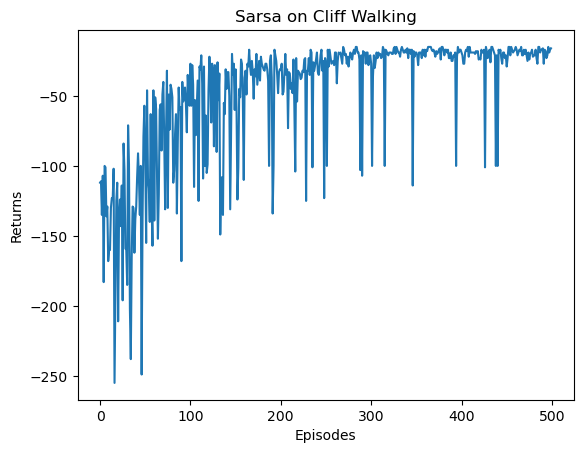

In [13]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

#print(return_list)
episodes_list = list(range(len(return_list)))
#print(episodes_list)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [14]:
q = np.zeros([2, 3])
q

array([[0., 0., 0.],
       [0., 0., 0.]])

In [15]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                #print('a',a)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
Q_max -7.595311851030769
ooo> Q_max -7.365895153992641
ooo> Q_max -7.105942770533638
ooo> Q_max -6.811779447184287
ooo> Q_max -6.484652703819601
ooo> Q_max -6.110683905225395
ooo> Q_max -5.6903978366495584
ooo> Q_max -5.234417160367265
ooo> Q_max -4.723257653721479
ooo> Q_max -4.1593098483302215
ooo> Q_max -3.5410845654478855
ooo> Q_max -2.81596464074976
ovoo 
Q_max -7.758510269929751
ooo> Q_max -7.439582381252048
ooo> Q_max -7.127362149443756
ooo> Q_max -6.7540549488584265
ooo> Q_max -6.357576486887186
ooo> Q_max -5.888986699439452
ooo> Q_max -5.405541458850802
ooo> Q_max -4.87461904160122
ooo> Q_max -4.298511971013306
ooo> Q_max -3.6503500152582826
ooo> Q_max -2.818043120130451
ooo> Q_max -1.9228583332250624
ovoo 
Q_max -7.995700867503767
^ooo Q_max -7.336031849038688
ooo> Q_max -6.922808378574841
^ooo Q_max -6.195397041995951
ooo> Q_max -5.911490144021739
ooo> Q_max -6.184079122246262
ooo> Q_max -5.166935135733786
ooo> Q_max -4.974296295172506
^ooo Q_max -4.699752

In [16]:
class nstep_Sarsa:
    """ n步Sarsa算法 """
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n  # 采用n步Sarsa算法
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:  # 若保存的数据可以进行n步更新
            G = self.Q_table[s1, a1]  # 得到Q(s_{t+n}, a_{t+n})
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]  # 不断向前计算每一步的回报
                # 如果到达终止状态,最后几步虽然长度不够n步,也将其进行更新
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)  # 将需要更新的状态动作从列表中删除,下次不必更新
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        if done:  # 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3581.08it/s, episode=500, return=-19.100]


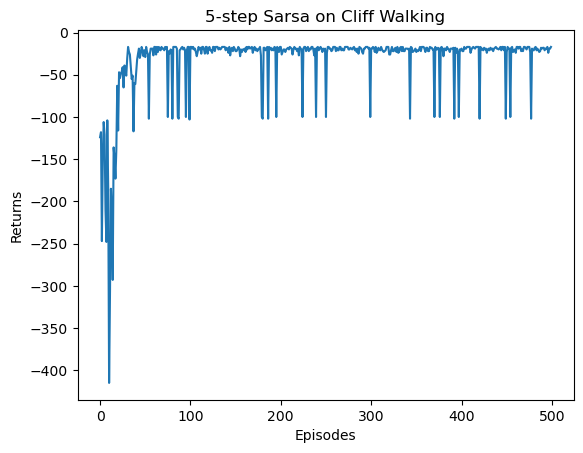

In [17]:
np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action,
                             done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [18]:
action_meaning = ['^', 'v', '<', '>']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [19]:
class QLearning:
    """ Q-learning算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4557.34it/s, episode=500, return=-61.700]


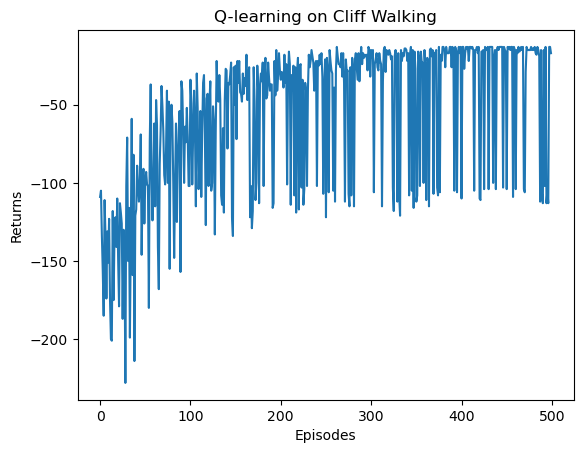

Q-learning算法最终收敛得到的策略为：
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [20]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [22]:
class DynaQ:
    """ Dyna-Q算法 """
    def __init__(self,
                 ncol,
                 nrow,
                 epsilon,
                 alpha,
                 gamma,
                 n_planning,
                 n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.n_planning = n_planning  #执行Q-planning的次数, 对应1次Q-learning
        self.model = dict()  # 环境模型

    def take_action(self, state):  # 选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0, a0, r, s1):
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = r, s1  # 将数据添加到模型中
        for _ in range(self.n_planning):  # Q-planning循环
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)

In [32]:
d={'yi':{'a':1,'b':2},'er':{'c':3,'d':4}}
print(list(d.items()))
(s, a), (r, s_) = random.choice(list(d.items()))
(s, a), (r, s_),random.choice(list(d.items()))

[('yi', {'a': 1, 'b': 2}), ('er', {'c': 3, 'd': 4})]


(('y', 'i'), ('a', 'b'), ('yi', {'a': 1, 'b': 2}))

In [43]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                #print('return_list.shape',len(return_list))
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3760.25it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2148.46it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 448.96it/s, episode=300, return=-13.400]


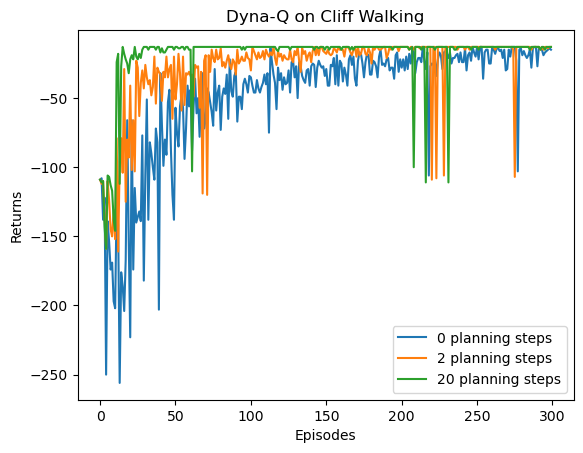

In [42]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()